In [1]:
# Implement the Vanilla GAN & Dataset balanced using Vanilla GAN

In [2]:
!pip install -q datasets torch torchvision matplotlib numpy

Dataset splits: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 251
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 66
    })
})
Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Covid', 'Normal', 'Viral Pneumonia'], id=None)}
Sample 1: Label = 0, Image = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4248x3480 at 0x7F2B0D2D9AC0>


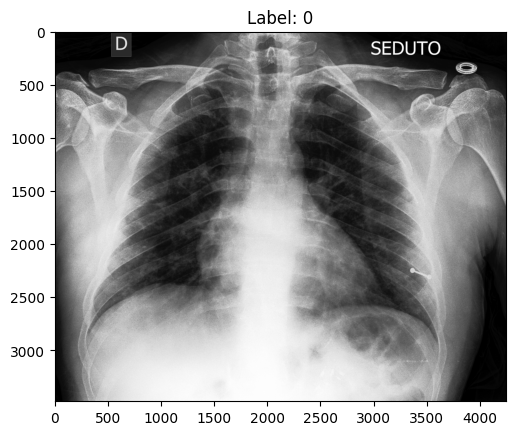

Sample 2: Label = 0, Image = <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1458x1303 at 0x7F2ADFCEBC70>


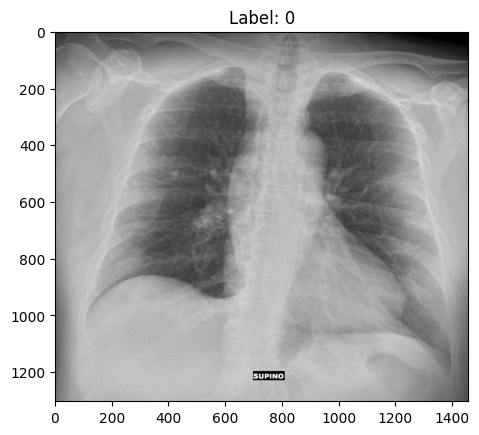

Sample 3: Label = 0, Image = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2500x2048 at 0x7F2B0C847B50>


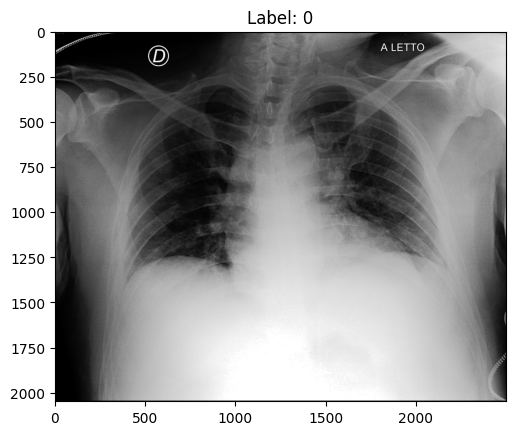

Sample 4: Label = 0, Image = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2972x2840 at 0x7F2B0C85F550>


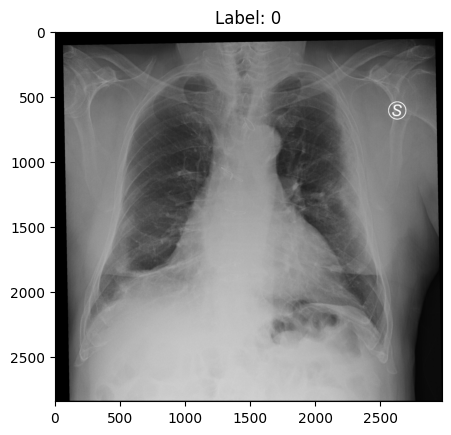

Sample 5: Label = 0, Image = <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=955x954 at 0x7F2B0C7CD850>


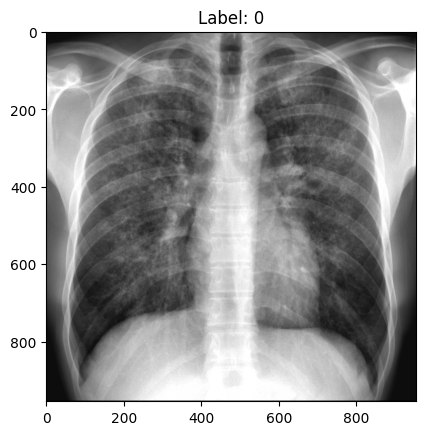

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# the dataset
dataset = load_dataset("yuighj123/covid-19-classification")

# the dataset structure
print("Dataset splits:", dataset)
print("Features:", dataset["train"].features)

# Show first 5 samples
for i in range(5):
    sample = dataset["train"][i]
    print(f"Sample {i+1}: Label = {sample['label']}, Image = {sample['image']}")
    plt.imshow(sample["image"].convert("RGB"))
    plt.title(f"Label: {sample['label']}")
    plt.show()

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#  see and Preprocess the Dataset
dataset = load_dataset("yuighj123/covid-19-classification")
label_names = dataset["train"].features["label"].names
num_classes = len(label_names)

# Preprocessing transform for GAN (64x64 images)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Custom Dataset class
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        image = sample["image"].convert("RGB")
        label = sample["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

# Split dataset by class
minority_classes = ["Normal", "Viral Pneumonia"]
dataloader_dict = {}

for class_name in minority_classes:
    class_idx = label_names.index(class_name)
    class_samples = [sample for sample in dataset["train"] if sample["label"] == class_idx]
    ds = HFDataset(class_samples, transform=transform)
    dataloader = DataLoader(ds, batch_size=32, shuffle=True)
    dataloader_dict[class_name] = dataloader
    print(f"{class_name} DataLoader size: {len(dataloader)} batches")

#  Define Vanilla GAN Models
latent_dim = 100
img_channels = 3
img_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

#  Train GANs with Fewer Epochs
def train_gan(dataloader, class_name, num_epochs=10):
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    fixed_noise = torch.randn(16, latent_dim, device=device)

    os.makedirs("generated_samples", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    for epoch in range(num_epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(real_images), real_labels)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_images), real_labels)
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample_images = generator(fixed_noise).cpu()
                save_image(sample_images, f"generated_samples/{class_name}_epoch_{epoch+1}.png", normalize=True)

    torch.save(generator.state_dict(), f"models/generator_{class_name}.pt")
    return generator

# Train GANs for minority classes
generators = {}
for class_name in minority_classes:
    dataloader = dataloader_dict[class_name]
    generators[class_name] = train_gan(dataloader, class_name, num_epochs=10)

#  Generate Synthetic Sample to balance the dataset
def generate_synthetic_images(generator, class_name, num_samples=41):
    os.makedirs(f"data/synthetic_{class_name}", exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            fake_img = generator(z).cpu().squeeze(0)
            fake_img = (fake_img + 1) / 2  # Denormalize to [0, 1]
            save_image(fake_img, f"data/synthetic_{class_name}/synth_{i}.png")

for class_name in minority_classes:
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(f"models/generator_{class_name}.pt"))
    generate_synthetic_images(generator, class_name, num_samples=41)

#  Balance the Dataset
def load_synthetic_images(class_name, num_samples=41):
    synthetic_images = []
    for i in range(num_samples):
        img_path = f"data/synthetic_{class_name}/synth_{i}.png"
        img = Image.open(img_path).convert("RGB")
        synthetic_images.append({"image": img, "label": label_names.index(class_name)})
    return synthetic_images

# Combine original and synthetic data
balanced_dataset = list(dataset["train"])
for class_name in minority_classes:
    synthetic_samples = load_synthetic_images(class_name, num_samples=41)
    balanced_dataset.extend(synthetic_samples)


2025-05-25 14:32:20.229972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 14:32:21.707519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748176342.073138    7321 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748176342.199360    7321 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748176343.304066    7321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Normal DataLoader size: 3 batches
Viral Pneumonia DataLoader size: 3 batches
Epoch [1/10] D Loss: 0.3785 G Loss: 3.6070
Epoch [2/10] D Loss: 0.1262 G Loss: 4.0199
Epoch [3/10] D Loss: 0.0823 G Loss: 4.4609
Epoch [4/10] D Loss: 0.0654 G Loss: 4.5394
Epoch [5/10] D Loss: 0.0472 G Loss: 4.9652
Epoch [6/10] D Loss: 0.0538 G Loss: 5.0374
Epoch [7/10] D Loss: 0.0396 G Loss: 5.3172
Epoch [8/10] D Loss: 0.0283 G Loss: 5.2577
Epoch [9/10] D Loss: 0.0342 G Loss: 5.3982
Epoch [10/10] D Loss: 0.0503 G Loss: 5.4264
Epoch [1/10] D Loss: 0.4512 G Loss: 3.3808
Epoch [2/10] D Loss: 0.1045 G Loss: 3.8562
Epoch [3/10] D Loss: 0.1086 G Loss: 4.2589
Epoch [4/10] D Loss: 0.0588 G Loss: 4.6785
Epoch [5/10] D Loss: 0.0535 G Loss: 4.7035
Epoch [6/10] D Loss: 0.0498 G Loss: 4.8549
Epoch [7/10] D Loss: 0.0440 G Loss: 4.9663
Epoch [8/10] D Loss: 0.0359 G Loss: 5.1567
Epoch [9/10] D Loss: 0.0321 G Loss: 5.3273
Epoch [10/10] D Loss: 0.0230 G Loss: 5.3838


In [6]:

#  Preprocess for CNN
def preprocess_image_for_cnn(image, target_size=(224, 224)):
    try:
        # Convert to PIL Image if not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image).astype(np.uint8))
        # Ensure RGB and resize
        image = image.convert('RGB')
        image = image.resize(target_size, Image.Resampling.LANCZOS)  # Use LANCZOS for better quality
        # Convert to NumPy and normalize
        image_array = np.array(image, dtype=np.float32) / 255.0
        # Explicit shape check
        if image_array.shape != (224, 224, 3):
            raise ValueError(f"Image shape {image_array.shape} does not match expected (224, 224, 3)")
        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Prepare training data
train_images = []
train_labels = []
for idx, sample in enumerate(balanced_dataset):
    img = preprocess_image_for_cnn(sample["image"], target_size=(224, 224))
    if img is not None:
        train_images.append(img)
        train_labels.append(sample["label"])
    else:
        print(f"Skipping invalid training image at index {idx} for label {sample['label']}")

train_images = np.array(train_images, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
print(f"Train images shape: {train_images.shape}")

# Prepare validation data with debugging
val_images = []
val_labels = []
for idx, sample in enumerate(dataset["test"]):
    img = preprocess_image_for_cnn(sample["image"], target_size=(224, 224))
    if img is not None:
        if img.shape != (224, 224, 3):
            print(f"Validation image at index {idx} has unexpected shape: {img.shape}")
        else:
            val_images.append(img)
            val_labels.append(sample["label"])
    else:
        print(f"Skipping invalid validation image at index {idx} for label {sample['label']}")

try:
    val_images = np.array(val_images, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.int32)
    print(f"Validation images shape: {val_images.shape}")
except ValueError as e:
    print(f"Error converting validation images to NumPy array: {e}")
    # Debug shapes of all validation images
    for i, img in enumerate(val_images):
        print(f"Validation image {i} shape: {img.shape}")
    raise

#  Train CNN
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

#  Evaluate
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)

print("\nClassification Report:")
print(classification_report(val_labels, val_pred_labels, target_names=label_names))

cm = confusion_matrix(val_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.close()

Train images shape: (333, 224, 224, 3)
Validation images shape: (66, 224, 224, 3)
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3958 - loss: 4.0643 - val_accuracy: 0.4545 - val_loss: 1.0217
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5603 - loss: 0.9746 - val_accuracy: 0.6667 - val_loss: 0.7793
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7369 - loss: 0.6133 - val_accuracy: 0.6515 - val_loss: 0.7354
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8111 - loss: 0.4445 - val_accuracy: 0.8030 - val_loss: 0.5646
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8599 - loss: 0.3546 - val_accuracy: 0.8182 - val_loss: 0.4806
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9034 - loss: 0.3132 - val_accuracy: 0.8485 - val_loss: 0.4411
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8768 - loss: 0.2947 - val_accuracy: 0.8636 - val_loss: 0.3401
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━